In [ ]:
!unzip 'data.zip'

Archive:  data.zip
  inflating: data/hinglish_stopwords.txt  
   creating: data/test/
  inflating: data/test/Hindi_test_unalbelled_conll_updated.txt  
  inflating: data/test/test_labels_hinglish.txt  
   creating: data/train/
  inflating: data/train/dev_3k_split_conll.txt  
  inflating: data/train/train_14k_split_conll.txt  
  inflating: data/train/train_conll.txt  
  inflating: data/train/trial_conll.txt  


In [ ]:
!pip install tensorflow
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 10/10 [2:07:19<00:00, 763.92s/trial, best loss: 2.6953611373901367]
Best Hidden Units: 128
Best Dropout Rate: 0.3104887459656341
Best Loss: 2.6953611373901367
Best Accuracy: 0.5368351340293884


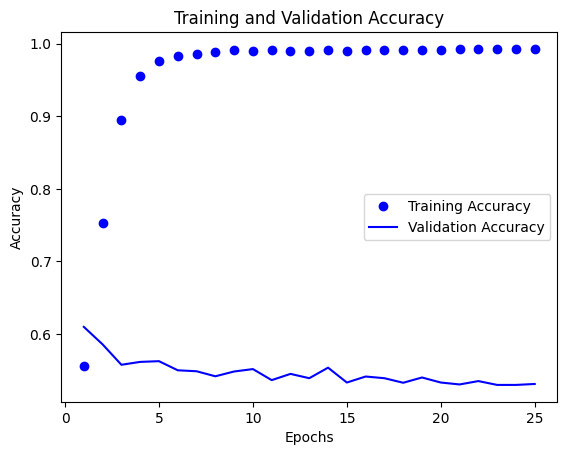

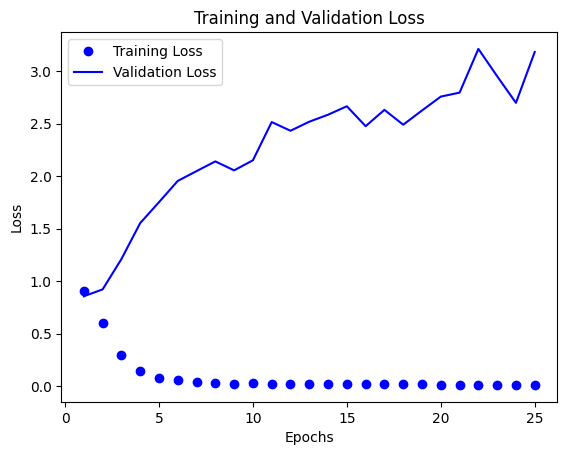

95/95 [==============================] - 3s 26ms/step
F1 Score:  0.5303179070040052



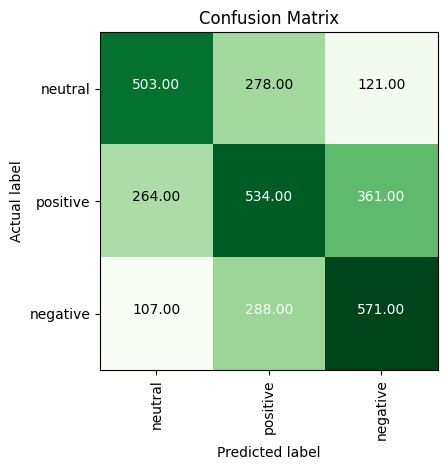

In [ ]:
import re
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from hyperopt import hp
from hyperopt import Trials
from hyperopt import fmin, tpe
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

class Tweet:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''


def cleanTweet(tweet):
    tweet.content = re.sub(r'\_', '', tweet.content) # remove underscores
    tweet.content = re.sub(r'…', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'\.', '', tweet.content) # remove elipses/dots
    tweet.content = re.sub(r'^RT[\s]+', '', tweet.content) # remove RT
    tweet.content = re.sub("[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', tweet.content) # remove weird symbols
    tweet.content = tweet.content.split("http")[0].split('https')[0] # remove http/https
    tweet.content = ''.join([i for i in tweet.content if not i.isdigit()]) # remove digits
    tweet.content = ''.join([word for word in tweet.content if word not in string.punctuation]) # remove punctuations
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet.content = tokenizer.tokenize(tweet.content)
    tweet.content = ' '.join([i for i in tweet.content]) # convert to string
    return tweet

def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('data/hinglish_stopwords.txt', 'r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, _ = load_stop_words()
    all_tweets = []
    with open(filename, 'r', encoding="utf8") as fp:
        tweet = Tweet()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one:
                if last_one or line.split()[0] == 'meta':
                    if len(tweet.content) > 0 or last_one:
                        all_tweets.append(cleanTweet(tweet))
                        if last_one:
                            break
                        tweet = Tweet()
                    tweet.uid = line.split()[1]
                    tweet.sentiment = line.split()[2] if not test_data else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            tweet.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        tweet.content += line.split()[0] + " "
                    else:
                        tweet.content += line.split()[0] + " "
    return all_tweets

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Greens):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral', 'positive', 'negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    plot_confusion_matrix(cnf_matrix)

all_tweets = readFile(r'data/train/train_conll.txt')

x_train = [i.content for i in all_tweets]
y_train = [i.sentiment for i in all_tweets]

# Preprocess the data
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text data to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to have the same length
max_sequence_length = 40
x_train_pad = pad_sequences(x_train_seq, maxlen=max_sequence_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_sequence_length)

# Define the objective function for hyperopt
def objective(params):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_sequence_length))
    model.add(LSTM(units=params['hidden_units']))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(units=3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train_pad, y_train, epochs=25, batch_size=32, validation_data=(x_test_pad, y_test), verbose=0)

    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    return {'loss': val_loss, 'status': 'ok', 'accuracy': val_accuracy}


# Define the search space for hyperparameters
search_space = {
    'hidden_units': hp.choice('hidden_units', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5)
}

# Run hyperparameter optimization using TPE algorithm
trials = Trials()
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10, trials=trials)

# Get the best hyperparameters and their performance
best_hidden_units = [32, 64, 128][best['hidden_units']]
best_dropout_rate = best['dropout_rate']
best_loss = trials.best_trial['result']['loss']
best_accuracy = trials.best_trial['result']['accuracy']

# Print the best hyperparameters and their performance
print("Best Hidden Units:", best_hidden_units)
print("Best Dropout Rate:", best_dropout_rate)
print("Best Loss:", best_loss)
print("Best Accuracy:", best_accuracy)

# Retrieve the final model's training history
best_model = Sequential()
best_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_sequence_length))
best_model.add(LSTM(units=best_hidden_units))
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(units=3, activation='softmax'))
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_history = best_model.fit(x_train_pad, y_train, epochs=25, batch_size=32, validation_data=(x_test_pad, y_test), verbose=0)

acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Perform prediction on test set
y_pred = np.argmax(best_model.predict(x_test_pad), axis=-1)

# Display evaluation results
show_results(y_test, y_pred)